In [1]:
#DATA CLEANING and MERGING

In [2]:
import pandas as pd

In [3]:
# Load the dataset
movies_metadata = pd.read_csv('./data/movies_metadata.csv')

# Convert budget, popularity, revenue, runtime, vote_average, and vote_count to numeric
numeric_columns = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
for col in numeric_columns:
    movies_metadata[col] = pd.to_numeric(movies_metadata[col], errors='coerce').fillna(0)

# Convert release_date to datetime
movies_metadata['release_date'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce')

# Drop unneeded columns
columns_to_drop = ['adult', 'homepage', 'poster_path', 'video']
movies_metadata.drop(columns=columns_to_drop, inplace=True)

C:\Users\Mallo\AppData\Local\Temp\ipykernel_7680\2315768313.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv('./data/movies_metadata.csv')


In [4]:
# load credits.csv into a DataFrame
credits = pd.read_csv('./data/credits.csv')

# Convert 'id' in credits to integer
credits['id'] = pd.to_numeric(credits['id'], errors='coerce').astype('Int64')

In [5]:
# load keywords.csv into a DataFrame
keywords = pd.read_csv('./data/keywords.csv')

# Convert 'id' in keywords to integer
keywords['id'] = pd.to_numeric(keywords['id'], errors='coerce').fillna(0).astype('Int64')

In [6]:
# Convert 'id' in movies_metadata to integer
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce').fillna(0).astype('Int64')

In [7]:
# Merge
movies_metadata = movies_metadata.merge(credits, on='id', how='left')
movies_metadata = movies_metadata.merge(keywords, on='id', how='left')

In [8]:
# Save the merged DataFrame to a new CSV file
movies_metadata.to_csv('./data/cleaned_merged_movies_data.csv', index=False)

In [9]:
import ast  # Import the Abstract Syntax Trees module

# Create DataFrame
df = pd.read_csv('./data/cleaned_merged_movies_data.csv')

# Parse the JSON-like strings in columns
def parse_column(text):
    try:
        # Convert the string to Python objects
        return ast.literal_eval(text)
    except ValueError:
        return []  # Return an empty list if there's any error
    except SyntaxError:
        return []  # Handle syntax error by returning an empty list

# Apply this function to the 'genres' column to convert from string to list
df['genres'] = df['genres'].apply(parse_column)

# Now, to extract just the names from the 'genres' column
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Preview the changes to the 'genres' column to confirm it's been cleaned
df['genres'].head()

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genres, dtype: object

In [10]:
# Apply the parsing function to the 'production_companies' column
df['production_companies'] = df['production_companies'].apply(parse_column)

# Extract company names
df['production_companies'] = df['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [11]:
# Apply the parsing function to the 'cast' column
df['cast'] = df['cast'].apply(parse_column)

# Extract names of the first few cast members, 5 for simplicity
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in x[:5]] if isinstance(x, list) else [])

In [12]:
# Apply the parsing function to the 'crew' column
df['crew'] = df['crew'].apply(parse_column)

# Extract names of directors
df['crew'] = df['crew'].apply(lambda x: [i['name'] for i in x if i['job'] == 'Director'] if isinstance(x, list) else [])

In [13]:
# Apply the parsing function to the 'keywords' column
df['keywords'] = df['keywords'].apply(parse_column)

# Extract keywords
df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [14]:
# WORKFLOW FOR BUILDING A CONTENT-BASED RECOMMENDATION SYSTEM

In [15]:
#Aggregate Text Features, Combine text features into one string
df['combined_features'] = df['overview'] + " " + df['genres'].apply(" ".join) + " " + df['keywords'].apply(" ".join) + " " + df['cast'].apply(" ".join) + " " + df['crew'].apply(" ".join)

In [16]:
# Fill NaN values in 'combined_features' with an empty string
df['combined_features'] = df['combined_features'].fillna('')

#TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the combined features
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_features'])

In [18]:
# This one will take FOREVER, but that's ok...
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel

# Further reduce the number of components
svd = TruncatedSVD(n_components=50)  # Adjusting n_components further
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

# Compute similarity on the reduced matrix
cosine_sim = linear_kernel(tfidf_matrix_reduced, tfidf_matrix_reduced)

In [19]:
#Recommendation Function
# Function to get movie recommendations based on cosine similarity
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = df.loc[df['title'] == title].index[0]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [20]:
test_movie_title = "Toy Story"
recommended_movies = get_recommendations(test_movie_title)
print(f"Recommendations for {test_movie_title}:")
recommended_movies

Recommendations for Toy Story:


7755                      Raising Helen
2852     Home Alone 2: Lost in New York
34813                  Love the Coopers
3055                      Stuart Little
1013              The Fox and the Hound
18356                       The Snowman
28905                    8 Minutes Idle
15444                       Toy Story 3
13808                                Up
31438     Tom and Jerry: The Magic Ring
Name: title, dtype: object

In [21]:
# PROGRAMMATICALLY SELECT A DIVERSE SET OF TEST MOVIES, 
#ENSURE THEY EXIST IN THE DATASET, 
#AND GENERATE RECOMMENDATIONS FOR EACH OF THEM.
#EASY-PEASY #HATERSgonnaHATE #PLAYERSgonnaPLATE

In [22]:
# Example to programmatically select a diverse set of test movies
test_movies = [
    "Toy Story",  # Animation/Comedy
    "Pulp Fiction",  # Crime/Drama
    "The Shining",  # Horror
    "Interstellar",  # Sci-Fi
    "The Grand Budapest Hotel",  # Comedy/Drama
    "Hereditary",  # Horror/Thriller
    "Moonlight",  # Drama
    "Mad Max: Fury Road",  # Action
    # Add more titles as needed to cover a wide range of genres and years
]

# Ensure all test movies are in the dataset
test_movies = [movie for movie in test_movies if movie in df['title'].values]

In [23]:
for movie in test_movies:
    print(f"Recommendations for {movie}:")
    recommendations = get_recommendations(movie)
    print(recommendations)
    print("\n" + "-"*60 + "\n")

Recommendations for Toy Story:
7755                      Raising Helen
2852     Home Alone 2: Lost in New York
34813                  Love the Coopers
3055                      Stuart Little
1013              The Fox and the Hound
18356                       The Snowman
28905                    8 Minutes Idle
15444                       Toy Story 3
13808                                Up
31438     Tom and Jerry: The Magic Ring
Name: title, dtype: object

------------------------------------------------------------

Recommendations for Pulp Fiction:
1856      The French Connection
9125                     Pusher
23133                     Chiko
3924                    Traffic
27211    The Last of the Finest
26910             Out of Bounds
3640                 Jesus' Son
4918            Another 48 Hrs.
156                    Clockers
451                       Fresh
Name: title, dtype: object

------------------------------------------------------------

Recommendations for The Shining:
19

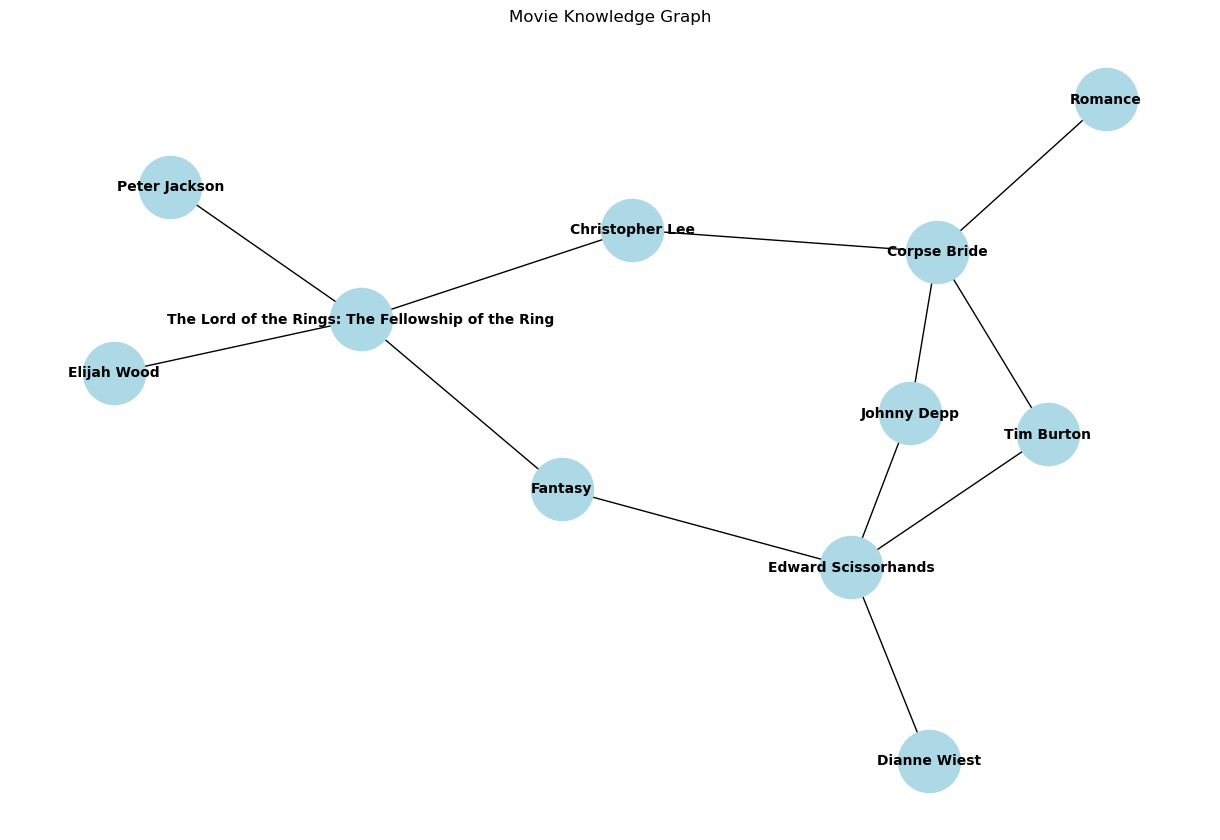

In [59]:
# MORE CLEANING AND PARSING JSON-LIKE STRING COLUMNS IN A DATAFRAME

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Corrected data dictionary variable name
KG_data = {
    'Movie': ['Corpse Bride', 'The Lord of the Rings: The Fellowship of the Ring', 'Edward Scissorhands'],
    'Director': ['Tim Burton', 'Peter Jackson', 'Tim Burton'],
    'Cast': [['Johnny Depp', 'Christopher Lee'], ['Christopher Lee', 'Elijah Wood'], ['Johnny Depp', 'Dianne Wiest']],
    'Genre': ['Romance', 'Fantasy', 'Fantasy']
}

# Convert the corrected data into a DataFrame
df = pd.DataFrame(KG_data)

# Create a graph
G = nx.Graph()

# Add nodes with the node attribute "type" and edges
for index, row in df.iterrows():
    G.add_node(row['Movie'], type='Movie')
    G.add_node(row['Director'], type='Director')
    for actor in row['Cast']:
        G.add_node(actor, type='Actor')
    G.add_node(row['Genre'], type='Genre')

    # Add edges
    G.add_edge(row['Movie'], row['Director'])
    for actor in row['Cast']:
        G.add_edge(row['Movie'], actor)
    G.add_edge(row['Movie'], row['Genre'])

# Visualization
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold")
plt.title("Movie Knowledge Graph")
plt.show()


In [52]:
# Assuming the CSV file is located in the './data/' directory
file_path = './data/cleaned_merged_movies_data.csv'
# Read the CSV file into a DataFrame
cleaned_merged_movies_data = pd.read_csv(file_path)
# Display the DataFrame
cleaned_merged_movies_data


,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,keywords
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"{'id': 96871, 'name': 'Father of the Bride Col...",0.0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46627,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,[],...,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,4.0,1.0,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...","[{'id': 10703, 'name': 'tragic love'}]"
46628,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]",...,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,9.0,3.0,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...","[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46629,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,"[{'name': 'American World Pictures', 'id': 6165}]",...,90.0,"[{'iso_639_1': 'en', 'name'

In [57]:
import pandas as pd

# Assuming 'release_date' is in the format 'YYYY-MM-DD' and your DataFrame is cleaned_merged_movies_data
# Convert 'release_date' to datetime format
cleaned_merged_movies_data['release_date'] = pd.to_datetime(cleaned_merged_movies_data['release_date'])

# Extract year from 'release_date'
cleaned_merged_movies_data['year'] = cleaned_merged_movies_data['release_date'].dt.year

# Convert year to decade
cleaned_merged_movies_data['decade'] = (cleaned_merged_movies_data['year'] // 15) * 15


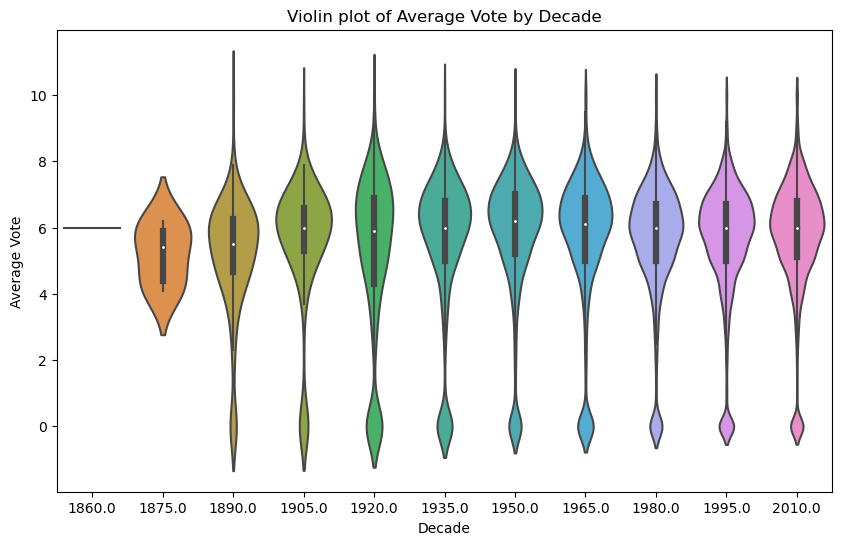

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure this DataFrame exists and has the columns 'decade' and 'vote_average'
# This is just an example; replace 'decade' and 'vote_average' with your actual column names
plt.figure(figsize=(10, 6))
sns.violinplot(x='decade', y='vote_average', data=cleaned_merged_movies_data)

plt.title('Violin plot of Average Vote by Decade')
plt.xlabel('Decade')
plt.ylabel('Average Vote')

plt.show()


In [ ]:
#FIN